In [346]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


# Feature selection done by elastic net 

Before a lasso regression was applied, but lead to not profound set of predictors, each model run lead to a nearly complete new selection of feautres. Therefore and in regard to strong multicollinearity (see pearson Correlation plot) a Elastic Net is tested.

Elastic Net combines feature elimination from Lasso and feature coefficient reduction from the Ridge model to improve your model’s predictions.

*Sources*
Geron 2019: https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch04.html#idm45022190228392

In [347]:
import sys
from glob import glob
import numpy as np
import pandas as pd

import pickle
import joblib

from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, RepeatedStratifiedKFold, RepeatedKFold, cross_val_score, cross_validate
from sklearn.compose import TransformedTargetRegressor

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

sys.path.insert(0, "../../../")
import utils.utils_feature_selection as fs
import utils.utils_evaluation as e
import utils.utils_figures as f
import utils.settings as s
import utils.pipelines_continous as p

s.init()
seed = s.seed

import warnings
warnings.filterwarnings('ignore')



In [414]:
df_candidates = pd.read_excel("../../../input_survey_data/input_data_contentloss.xlsx")
#df_candidates = pd.read_excel("../../../input_survey_data/input_data_businessreduction.xlsx")

targets = ["Target_contentloss_euro", "Target_businessreduction"]
target = targets[0]

print(df_candidates.shape)
df_candidates.tail(2)


(397, 42)


,Target_contentloss_euro,inundation_duration_h,water_depth_cm,contaminations.0,flowvelocity,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.6,...,shp_risk_tolerance,shp_monetary_resources4prevention,resilience_city_protection,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,contaminations_light,contaminations_heavy,shp_content_value_euro,shp_registered_capital_euro
395,0.0,4.0,70.0,0,1,1,0,1,0,1,...,3.0,3.0,1.0,5,1.0,2.0,1,0,NaN,11047.7
396,0.0,3.0,100.0,0,1,1,0,1,0,0,...,3.0,4.0,NaN,5,NaN,3.0,1,0,NaN,736.5


## Clean dataset from features and records with too many missing values


In [415]:
## delete features with more than 10% missing values
print("Percentage of missing values per feature\n", df_candidates.isna().mean().sort_values(ascending=False)[:15] ) 
#df_candidates = df_candidates[df_candidates.columns[df_candidates.isna().mean() < 0.10]]  # drop feautres with more than 10% missing values
#print(df_candidates.isna().sum(axis=0).sort_values(ascending=False))
## --> drops content values if threshold == 15%


Percentage of missing values per feature
 elevation_building_height_cm                   0.158690
shp_content_value_euro                         0.158690
shp_registered_capital_euro                    0.118388
perception_who_responsible4protection.Rank1    0.070529
shp_risk_tolerance                             0.070529
bage                                           0.068010
hh_monthly_income_cat                          0.060453
shp_monetary_resources4prevention              0.045340
resilience_city_protection                     0.037783
Target_contentloss_euro                        0.037783
resilience_neighbor_management                 0.027708
inundation_duration_h                          0.022670
b_area                                         0.005038
water_depth_cm                                 0.002519
emergency_measures.7                           0.000000
dtype: float64


In [416]:
# ## TODO fix missing values by filling or removing them:
# ## Idea: remove nan in targets (->get 2 ds) and fill missing values in candidate predictors
# ## or think about to remove predictors with very many missing values , even they are significant correlated to target eg. warning time

## number of missing values for each predictor and for each case
# df_candidates_t.isna().sum().sort_values(ascending=False)
#t = df_candidates_t.drop(["perception_govern_support_future", "warning_time_h"], axis=1)
# t.isna().sum().sum()

# df_candidates.isna().sum(axis=1).sort_values(ascending=False) # nan per case


### Test drop features with high correlation to other features

### Test drop features with variance around zero

In [417]:
# pd.options.display.float_format = '{:.5f}'.format

# df_variance = pd.DataFrame({"name": df_candidates.columns, "variance": df_candidates.var(), }).reset_index(drop=True)
# df_variance = df_variance.loc[df_variance.variance > 0.0000, :]
# print(df_variance.shape)
# df_variance.variance = df_variance.variance.astype(float)
# df_variance.sort_values("variance", ascending=True) [:10]
# ## same result as with # from sklearn.feature_selection import VarianceThreshold


Except for contamination types and supplier location the dataset fro buisness reduction hasnt much options for feature redction based on small variance scores close to zero. 
For content loss variable no suitable feautre with low variance could be find. 
*CHECK if correct: Some variabels have small variance due that they were quite ofte napplied e.g.emergency measures and therefoe just show a small variation from their mean value ?*

In [418]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# df_vif = pd.DataFrame()
# df_vif["features"] = X_unscaled.columns
# df_candidates_X_filled = X_unscaled.replace(np.nan, 0)
# df_vif["vif_scores"] = [variance_inflation_factor(df_candidates_X_filled.values.astype(float), i)  for i in range(len(df_candidates_X_filled.columns))]
# df_vif.sort_values("vif_scores", ascending=False)  

# print("averaged VIF score is around: ", round(df_vif.vif_scores.mean(),1))
# print(df_vif.sort_values("vif_scores", ascending=False)  )
# # VIF >5 : high correlation
# # VIF 1-10: medium correlation


## select only observations with content loss

In [419]:
# t = df_candidates.iloc[df_candidates[target].nlargest(10), :]
# t.describe()
# t.hist() #bins=20, figsize=(8, 8))
# # plt.ylim(1, 20)
# # plt.xlim(1, 20000)
# # plt.show()

In [420]:
# print(f"Removing {df_candidates.loc[df_candidates[target]==0,:].shape[0]} zero loss records")
# df_candidates = df_candidates.loc[df_candidates[target]!=0,:]

# print(f"Keeping {df_candidates.shape} damage cases for model training and evaluation")

### Test remove and merging further features

In [421]:
#df_candidates.info()

#df_candidates = df_candidates.dropna()

In [422]:
# from sklearn import preprocessing

# scaler = preprocessing.MinMaxScaler()
# d = scaler.fit_transform(X_unscaled)
# X_scaled = pd.DataFrame(d, columns=X_unscaled.columns)

# df_vif = pd.DataFrame()
# df_vif["X_features"] =  X_unscaled.columns

# ## fill possible important features with median, only for VIF calculation
# for f in ["shp_registered_capital_euro", "elevation_building_height_cm",  "shp_content_value_euro"]:
#     X_scaled[f"{f}"] = X_scaled[f"{f}"].replace(np.nan, np.nanmedian(X_scaled[f"{f}"]))

# X_scaled_drop_nan = X_scaled.dropna()

# print(X_scaled.shape)
# print(X_scaled_drop_nan.shape)

# df_vif = fs.vif_score(X_scaled_drop_nan)
# print(df_vif.sort_values("vif_scores", ascending=False).head(15)  )
# # VIF >10 : high correlation with other features
# # VIF 1-5: medium correlation

In [423]:
df_candidates = df_candidates.drop([
        "contaminations_light", "contaminations_heavy", "emergency_measures.9",
        "emergency_measures.6", "emergency_measures.7", # BETTER DROP test rmv da nur binary
        "elevation_rel2surrounding_cat",  # TEST
        #"shp_profits_last5years", # TEST
        "shp_monetary_resources4prevention", # TEST
        'shp_finance_investments',
        'shp_risk_tolerance',
        'resilience_city_protection', 'resilience_left_alone',
        'resilience_neighbor_management', 
        # already in d_cleaning RM 'resilience_more_future_affected','resilience_govern_careing', 'resilience_govern_careing_increases',
        'perception_who_responsible4protection.Rank1',
        # ALREADY RM in d_cleaning: 'perception_private_economy_future' 
        ], axis=1)


(397, 29)


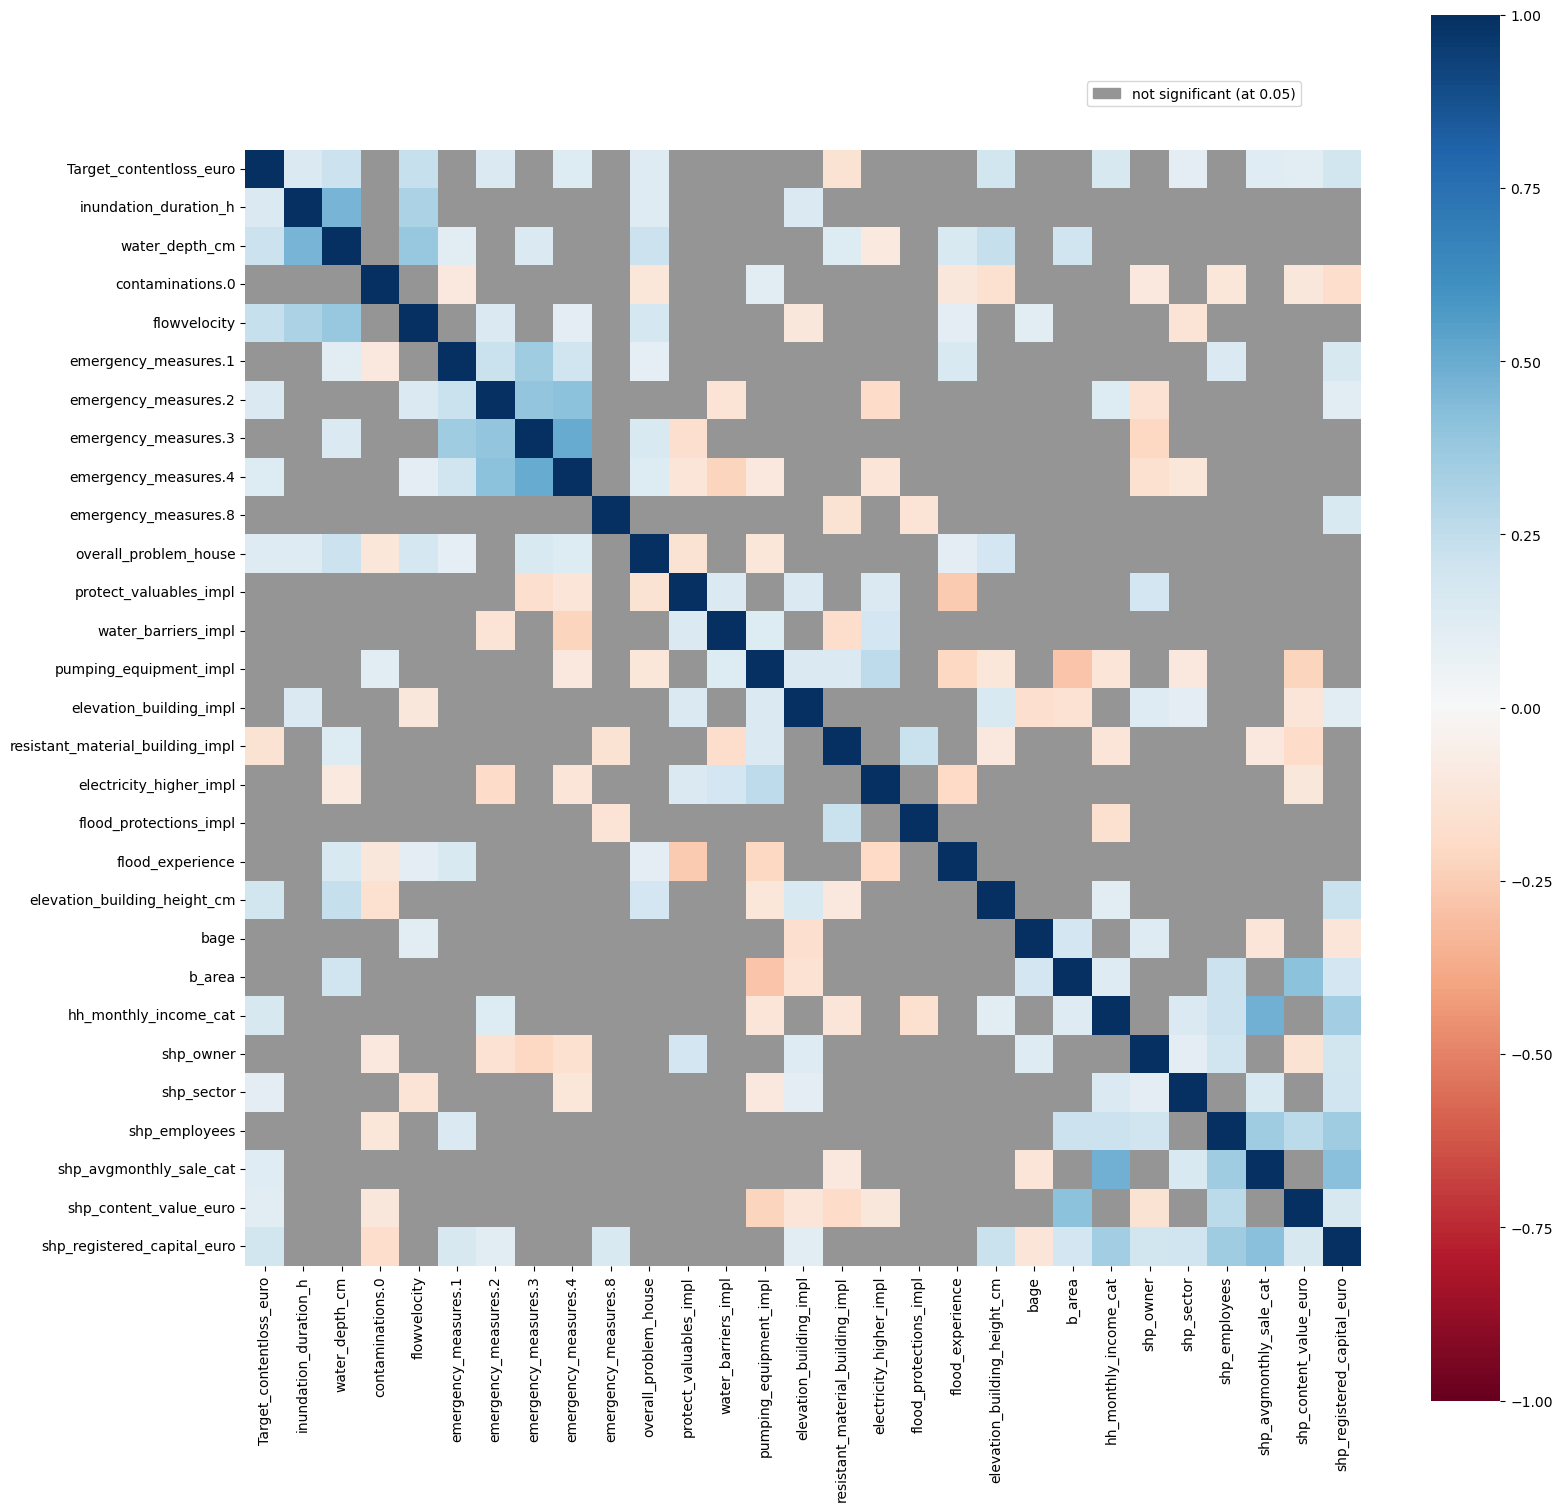

In [424]:
print(df_candidates.shape)

f.plot_spearman_rank(df_candidates, min_periods=10, signif=True, psig=0.05)


## Fit model and select features

In [359]:
## Hyperparameter ranges to test

param_grid = {
    "model__alpha": [ 0.1, 1, 2, 3, 4, 5, 6],      # alpha: constant mulitplies penality term, alpha = 0 is equivalent to an OLS solved by the LinearRegression
    "model__max_iter": [1,2,3,4,5, 8, 10],
    "model__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0],     # r = 0, equivalent to Ridge Regression (=L2),  r = 1 equivalent to Lasso Regression (=L1) 
    "model__tol": [0.5, 0.7, 1.0, 2.0 ,5.0, 10.0],
     "model__selection": ["cyclic", "random"],
    # "model__positive": [True],
    # "model__random_state": [seed],
}

## paramter names when bootstrapping mehtod is applied
param_bag_grid = { k.replace('model', 'bagging__estimator') : v for (k, v) in param_grid.items()}



param_bagging = {
    'bootstrap': [True, False],
    'random_state': [seed]
    # 'bootstrap_features': [True, False],
    # 'n_estimators': [20,50,100],
    # 'max_samples': [0.5,1.0, X_train.shape[0]//2,],
    # 'max_features': [0.5,1.0, X_train.shape[1]//2,],
    # oob_score
}
## TODO add hyperparams for Bagging: 
## current defaults: n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False


In [360]:
#print("Percentage of missing valeus per feature\n", df_candidates.isna().mean().sort_values(ascending=False)[:7] ) 


In [361]:
## iterate over both targets and store results 

eval_set_list = []

targets = ["Target_contentloss_euro", "Target_businessreduction"]
print(target)

## iterate over piplines. Each piplines contains precrosseing methods and several  classifier
#pipelines = ["pipe_bag_en"]#, 
pipelines = ["pipe_en" ]#, "pipe_ximput_logr"]


for pipe_name in pipelines:

    print( f"\nApply Elastic Net on {target}, with pipeline {pipe_name}:")

    ## load sinlge pipeline
    pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')
        

    df_candidates_t = df_candidates

    # # ##impute nans in X
    # for c in df_candidates_t.drop(target, axis=1): 
    #     #df_candidates_t[f"{c}"].fillna(value=np.nanmedian(df_candidates_t[f"{c}"]), inplace=True)
    #     df_candidates_t[c].fillna(df_candidates_t[c].median(), inplace=True)
 
     # print("Uses ", df_candidates_t.shape[0], " records, from those have ", 
    #       { (df_candidates_t[target][df_candidates_t[target]==0.0]).count() }, f" records zero {target.split('_')[1]}")

    ## clean df from all records containg nan
    df_candidates_t = df_candidates_t.dropna()
    ## clean df from nan in target
    df_candidates_t = df_candidates_t[ ~df_candidates_t[f"{target}"].isna()]


    X_unscaled = df_candidates_t.drop(target, axis=1)  # remove  target from X
    y = df_candidates_t[target]
 
    ## test train split
    X_train, X_test, y_train, y_test = train_test_split(
        X_unscaled, y, test_size=0.15, 
        random_state=seed, shuffle=True)
    
    ## save evaluation set for later usage in feature importance
    eval_set =  pd.concat([y_test, X_test], axis=1) #[(X_test, y_test)]
    eval_set_list.append({pipe_name : eval_set})

    ## normalize data 
    X_train, X_test = fs.normalize_X(X_train, X_test)
        
    print("Training size", X_train.shape)
    print("Test size", X_test.shape)
    
    # model = {'model': BaggingRegressor,   # default bootstrap=True
    #     'kwargs': {'estimator': ElasticNet()},  # TODO: pass 'random_state':seed to baggingregressor
    #     'parameters': param_grid,
    #     }
    ## Hyperparmaters and CV
    #cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)        #  StratifiedKFold = fold contains same percantega of class as in orignal training set, addresees imbalancing
    #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)        #  StratifiedKFold = fold contains same percantega of class as in orignal training set, addresees imbalancing
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=seed)
    model_cv = RandomizedSearchCV(
        estimator=pipe, 
        param_distributions=param_grid, #
        #param_distributions=param_bag_grid, 
        cv=cv, 
        scoring= "neg_mean_absolute_error",##"neg_mean_absolute_error", #"neg_mean_squared_error",#"r2" ,#"neg_mean_absolute_error",   #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
        refit=True,   ## Refit the best estimator with the entire dataset. If “False”, it is impossible to make predictions using this GridSearchCV instance after fitting.
                        ## If refit=False, clf.fit() will have no effect because the GridSearchCV object inside the pipeline will be reinitialized after fit().
                        ## ! When refit=True, the GridSearchCV will be refitted with the best scoring parameter combination on the whole data that is passed in fit()
        random_state=seed
    )
    ## Fit model
    model_cv.fit(X_train, y_train)   
    
    ## fit model again with best hyperparams
    print("Create new Elastic Net model based on best hyperparameters")
    model =  model_cv.best_estimator_

    ## store best trained model for evaluation
    filename = f'./models_trained/elasticnet_{target}_{pipe_name}.sav'
    pickle.dump(model, open(filename, 'wb'))

    ## Feature importance + selection
    importances = e.permutation_feature_importance(model, X_test, y_test, repeats=5, seed=seed)

    df_importance = pd.DataFrame(
        {"importances" : importances[0]},
        index=X_train.columns.to_list(),
        ) 
    df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
    print("Most important features:", df_importance.iloc[:5].index.to_list())
    df_importance = df_importance.loc[df_importance.importances >= 0.000 , : ]
    #df_importance.head(5)
    # ## write selected predictors and response to disk
    fs.save_selected_features(
        X_train, 
        pd.DataFrame(y_train, columns=[target]), 
        df_importance.T.columns, 
        filename=f"../../../input_survey_data/selected_predictors/fs_elasticnet_{target.split('_')[1]}_{pipe_name}.xlsx"
    )

    ## Evaluate
    ## print evaluation report + check for overfitting 
    print("\nTraining set")
    y_pred_train = model.predict(X_train)
    #y_pred_train = model_cv.best_estimator_.predict(X_train)
    e.evaluation_report(y_train, y_pred_train,
                         filepath=f"./models_evaluation/elastic_net/eval_train_{target.split('_')[1]}_{pipe_name}.csv")

    print("\nTesting set")
    y_pred = model.predict(X_test)
    e.evaluation_report(y_test, y_pred, 
                        filepath=f"./models_evaluation/elastic_net/eval_test_{target.split('_')[1]}_{pipe_name}.csv")
      


Target_businessreduction

Apply Elastic Net on Target_businessreduction, with pipeline pipe_en:
Training size (153, 34)
Test size (27, 34)
Create new Elastic Net model based on best hyperparameters
Most important features: ['bage', 'perception_private_economy_future', 'resilience_govern_careing', 'flowvelocity', 'flood_experience']
total features: 34
selected features: 19
dropped features: 15
selected features: 
['bage', 'perception_private_economy_future', 'resilience_govern_careing', 'flowvelocity', 'flood_experience', 'water_depth_cm', 'shp_owner', 'resilience_govern_warnings_helpful', 'shp_profits_last5years', 'resistant_material_building_impl', 'flood_protections_impl', 'shp_content_value_euro', 'emergency_measures.8', 'overall_problem_house', 'resilience_more_future_affected', 'protect_valuables_impl', 'emergency_measures.3', 'shp_suppliers_HCMC', 'elevation_building_height_cm']

Saving model to disk: ../../../input_survey_data/selected_predictors/fs_elasticnet_businessreduction_

In [362]:
# fi_cols =  df_importance.loc[df_importance.importances >= 0.0001 , : ].index.to_list()#.shape

# model = model_cv.best_estimator_
# model.fit(X_train.loc[:, fi_cols], y_train)

# print(len(fi_cols))

In [363]:
# y_pred_train_fi = model.predict(X_train.loc[:, fi_cols])
# e.evaluation_report(y_train, y_pred_train_fi)

# y_pred_fi = model.predict(X_test.loc[:, fi_cols])
# e.evaluation_report(y_test, y_pred_fi)


In [364]:
importances_cv = e.permutation_feature_importance(model_cv.best_estimator_, X_test, y_test, repeats=5, seed=seed)
importances_cv

df_importance = pd.DataFrame(
    {"importances" : importances_cv[0]},
    index=X_train.columns.to_list(),
    ) 
df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
print("Most important features:", df_importance.iloc[:5].index.to_list())
df_importance = df_importance.loc[df_importance.importances >= 0.0001, : ]

df_importance

Most important features: ['bage', 'perception_private_economy_future', 'resilience_govern_careing', 'flowvelocity', 'flood_experience']


,importances
bage,0.041559
perception_private_economy_future,0.039380
resilience_govern_careing,0.037630
flowvelocity,0.031579
flood_experience,0.021052
water_depth_cm,0.012803
shp_owner,0.007570
resilience_govern_warnings_helpful,0.006977
shp_profits_last5years,0.004885
resistant_material_building_impl,0.004471


In [365]:
# fi_cols =  df_importance.loc[df_importance.importances >= 0.0001 , : ].index.to_list()#.shape


# model_cv = RandomizedSearchCV(
#     estimator=pipe, 
#     param_distributions=param_grid, #
#     #param_distributions=param_bag_grid, 
#     cv=cv, 
#     scoring= "neg_mean_absolute_error",##"neg_mean_absolute_error", #"neg_mean_squared_error",#"r2" ,#"neg_mean_absolute_error",   #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
#     refit=True,   ## Refit the best estimator with the entire dataset. If “False”, it is impossible to make predictions using this GridSearchCV instance after fitting.
#                     ## If refit=False, clf.fit() will have no effect because the GridSearchCV object inside the pipeline will be reinitialized after fit().
#                     ## ! When refit=True, the GridSearchCV will be refitted with the best scoring parameter combination on the whole data that is passed in fit()
#     random_state=seed
# )
# ## Fit model
# model_cv.fit(X_train.loc[:, fi_cols], y_train)   

# print('Train R^2 Score : %.3f'%model_cv.best_estimator_.score(X_train.loc[:, fi_cols], y_train))
# print('Test R^2 Score : %.3f'%model_cv.best_estimator_.score(X_test.loc[:, fi_cols], y_test))
# #print("CV score: ", model_cv.best_score_ ,  model_cv.best_estimator_.score(X_train, y_train),  model_cv.best_estimator_.score(X_test, y_test))


# ## fit model again with best hyperparams
# print("Create new Elastic Net model based on best hyperparameters")
# model =  model_cv.best_estimator_


In [366]:
model_cv.best_params_

## basis: bred, test set /Train 26R2)
#    Model Performance:
#         Mean Squared Error: 856.8
#         Root Mean Square Error: 29.3
#         Mean Absolute Error: 22.7
#         Mean Absolute Percentage Error: inf
#         R²-Score: -0.16
#         Adjusted R²-Score: 2.32

{'model__tol': 0.5,
 'model__selection': 'random',
 'model__max_iter': 10,
 'model__l1_ratio': 0.75,
 'model__alpha': 0.1}

In [367]:
importances_cv = e.permutation_feature_importance(model_cv.best_estimator_, X_test, y_test, repeats=5, seed=seed)
importances_cv

df_importance = pd.DataFrame(
    {"importances" : importances_cv[0]},
    index=X_train.columns.to_list(),
    ) 
df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
print("Most important features:", df_importance.iloc[:5].index.to_list())
df_importance = df_importance.loc[df_importance.importances >= 0.0001, : ]

df_importance

Most important features: ['bage', 'perception_private_economy_future', 'resilience_govern_careing', 'flowvelocity', 'flood_experience']


,importances
bage,0.041559
perception_private_economy_future,0.039380
resilience_govern_careing,0.037630
flowvelocity,0.031579
flood_experience,0.021052
water_depth_cm,0.012803
shp_owner,0.007570
resilience_govern_warnings_helpful,0.006977
shp_profits_last5years,0.004885
resistant_material_building_impl,0.004471


In [368]:
# # #Snippet from: https://ubc-cs.github.io/cpsc330/lectures/08_hyperparameter-optimization.html#exhaustive-grid-search-sklearn-model-selection-gridsearchcv
# #pd.DataFrame(elastic_net_cv.cv_results_).set_index("rank_test_score").sort_index().T
# pd.DataFrame(model_cv.cv_results_)[
#         [                                   # only important cv evaluation metrics 
#             "mean_test_score",
#             "mean_fit_time",
#             "rank_test_score",
#             "param_bagging__estimator__alpha",
#             "param_bagging__estimator__l1_ratio",
#             "param_bagging__estimator__max_iter"
#         ]
#     ].set_index("rank_test_score").sort_index().T


#### Save best model, its hyperparamters, and evlation scores and selected features

In [369]:
## Stored best xgb model for business reduction: best_xgboost_Target_businessreduction_pipe_xgb.sav
## Its hyperaprams xgb_best_param_model_cv.best_params_  # early_stop=3

## best model and hyperparams (here early stoping =3)
filename = f'./models_trained/best_elasticnet_{target}_{pipe_name}.sav'
if not glob(filename):
    pickle.dump(model, open(filename, 'wb'))

best_params = model_cv.best_params_
best_params = pd.DataFrame({"hyperparameter":best_params.keys(), "value":best_params.values()})
filepath = f'./models_evaluation/best_elasticnet_hyperparams_{target}_{pipe_name}.sav'
if not glob(filepath):
    best_params.to_csv(filename, index = False)

# ## eval report
# y_pred_train = model.predict(X_train)
# e.evaluation_report(y_train, y_pred_train,
#                     filepath=f"./models_evaluation/elasticnet/best_eval_train_{target.split('_')[1]}_{pipe_name}.csv")
# y_pred = model.predict(X_test)
# e.evaluation_report(y_test, y_pred, 
#                     filepath=f"./models_evaluation/elasticnet/best_eval_test_{target.split('_')[1]}_{pipe_name}.csv")

# ## selected features
# fs.save_selected_features(
#         X_train, 
#         pd.DataFrame(y_train, columns=[target]), 
#         df_importance.T.columns, 
#         filename=f"../../../input_survey_data/selected_predictors/best_fs_elasticnet_{target.split('_')[1]}_{pipe_name}.xlsx"
#     )

## Evaluation

In [370]:
## reload models


#pipelines = ["pipe_bag_en"]#, 
pipelines = ["pipe_en" ]#
pipe_name = pipelines[0]

#model_eval = pickle.load(open(f"./models_trained/best_elasticnet_{target}_{pipe_name}.sav", 'rb'))
#elastic_net_eval.get_params()


['Target_contentloss_euro', 'Target_businessreduction']


In [371]:
print('R^2 training set', round(model.score(X_train, y_train)*100, 2), ' %')
print('R^2 test set', round(model.score(X_test, y_test)*100, 2))

R^2 training set 33.68  %
R^2 test set -12.89


### Feature importance

In [372]:
#model_eval.get_params()


In [373]:
print("if alpha < 0.5 used more Ridge regularization: \n" , model.get_params())

if alpha < 0.5 used more Ridge regularization: 
 {'memory': None, 'steps': [('model', ElasticNet(alpha=0.1, l1_ratio=0.75, max_iter=10, selection='random', tol=0.5))], 'verbose': False, 'model': ElasticNet(alpha=0.1, l1_ratio=0.75, max_iter=10, selection='random', tol=0.5), 'model__alpha': 0.1, 'model__copy_X': True, 'model__fit_intercept': True, 'model__l1_ratio': 0.75, 'model__max_iter': 10, 'model__positive': False, 'model__precompute': False, 'model__random_state': None, 'model__selection': 'random', 'model__tol': 0.5, 'model__warm_start': False}


In [378]:
X_unscaled.shape


(180, 34)

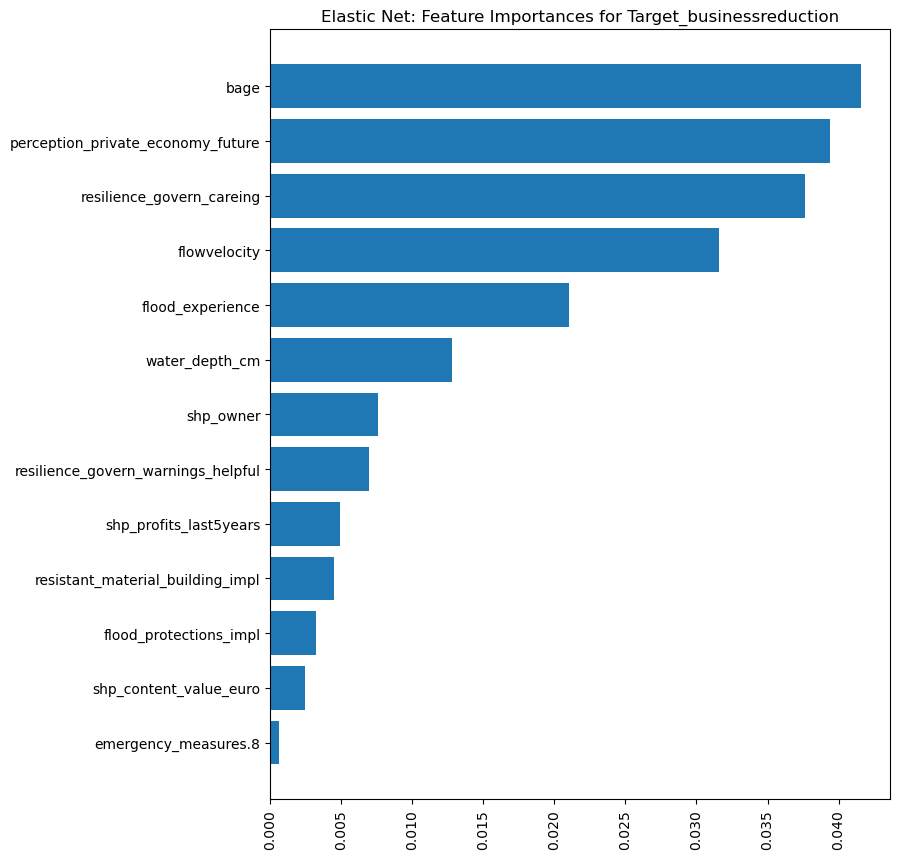

In [379]:
# plot feature importance
#fig, ax = plt.subplots(figsize=(12,5))

# relaod evalation set
eval_set = eval_set_list[0][pipe_name]

importances = e.permutation_feature_importance(model, 
                                               X_test,
                                               y_test,
                                               #eval_set.drop(target, axis=1), 
                                               #eval_set[target], 
                                               repeats=5, seed=seed
                                               )

## feature importance scores
df_importance = pd.DataFrame({
    "name" : X_unscaled.columns.to_list(),
    "importances" : importances[0],
     }) 

# drop features which dont reduce the loss
df_importance = df_importance.loc[df_importance.importances > 0.0000, : ] 
df_importance = df_importance.sort_values("importances", ascending=True)

plt.figure(figsize=(8, 10))
plt.barh(df_importance.name, df_importance.importances)
plt.xticks(
    #ticks = range(len(selected_feat)),
    #labels = X_unscaled.iloc[:,selected_feat],
    rotation = 90
    )
plt.title(f"Elastic Net: Feature Importances for {target}")
plt.show()

## save importnace scores  and figure
filepath = f'./models_evaluation/best_elasticnet_importance_scores_{target}_{pipe_name}'
if not glob(filepath):
    df_importance.to_csv(filename, index = False)


#plt.savefig(f'../../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')

In [ ]:
# coef = pd.Series(elastic_net.coef_, index = X_train.columns)
# important_features = pd.concat([coef.sort_values().head(10),
#                      coef.sort_values().tail(10)])
# important_features.plot(kind = "barh")
# plt.title("Coefficients in the ElasticNet Model")

### Plot optimal number of features

In [22]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head(2)
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_bagging__estimator__tol', 'param_bagging__estimator__selection',
       'param_bagging__estimator__random_state',
       'param_bagging__estimator__positive',
       'param_bagging__estimator__max_iter',
       'param_bagging__estimator__l1_ratio', 'param_bagging__estimator__alpha',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'split10_test_score', 'split11_test_score',
       'split12_test_score', 'split13_test_score', 'split14_test_score',
       'split15_test_score', 'split16_test_score', 'split17_test_score',
       'split18_test_score', 'split19_test_score', 'split20_test_score',
       'split21_test_score', 'split22_test_score', 'split23_test_score',
       'split24_test_score', 'split25_tes

In [25]:
#cv_results["params"][0]

In [ ]:

# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')